# Tensorflow 101

Tensorflow is an open-source library for numerical computations, focusing mostly on neural networks. By the end of this tutorial, you should be able to define a computational graph of a multi-layer perceptron and train it on a simple computer vision dataset.

Let's start by validating your installation.

In [ ]:
import sys
import tensorflow as tf
import numpy as np

major_version = sys.version_info[0]
if major_version < 3:
    print("You are running Python 2. This tutorial was tested in Python 3, " \
          "therefore, you might need to change some commands to make it work.")
else:
    print("Python ok.")
    
ver = tf.__version__.split(".")
tf_major = int(ver[0])
tf_minor = int(ver[1])

if tf_major < 1:
    print("You should upgrade your tensorflow to version 1.2.0.")
    print("Your version is:")
    print(tf.__version__)
else:
    if tf_minor >= 2:
        print("Tensorflow ok.")
    elif tf_minor == 1:
        print("You have tensorflow version 1.1.0. You should upgrade to 1.2.0 or 1.3.0.")

## Part 1: Tensors and computational graphs

This part of the tutorial is based on [Getting Started With TensorFlow](https://www.tensorflow.org/get_started/get_started).

There are two steps to running code in tensorflow.
1. Creating a computational graph
2. Executing a computational graph

Let's start with a simple example.

In [ ]:
# define two constants and an addition operation
x = tf.constant(2, tf.int32)
y = tf.constant(4, tf.int32)
add = tf.add(x, y)

# run the add operation
with tf.Session() as sess:
    result = sess.run(add)

print(result)

Instead of hardcoding the values, it's possible to provide them to the computational graph when we run it with **placeholders**.

In [ ]:
# define two placeholders
x = tf.placeholder(tf.int32)
y = tf.placeholder(tf.int32)
# shortcut for tf.add(x, y)
add = x + y

# create a feed dictionary
feed_dict = {
    x: 3,
    y: 7
}

# run the operation
with tf.Session() as sess:
    result = sess.run(add, feed_dict=feed_dict)
    
print(result)

Now it's time for you to experiment with tensorflow operations.
#### Task 1:
Define a simple integer operation.

* input: x, y, z (integer placeholders - the same as above)

* output: x * y + z

In [ ]:
x = tf.placeholder(tf.int32)
y = tf.placeholder(tf.int32)
z = tf.placeholder(tf.int32)

mult = x * y
add = mult + z

# create a feed dictionary
feed_dict = {
    x: 3,
    y: 7,
    z: 1
}

# run the operation
with tf.Session() as sess:
    result = sess.run(add, feed_dict=feed_dict)
    
print(result) 

So far, we've been dealing with integers, however, for machine learning tasks, we'll need to handle vectors and matrixes.

Tensorflow enables us to operate with **tensors**. Tensor is an array of any number of dimensions. Tensor's **rank** is its number of dimensions. In fact, the integer constants and placeholders we have been working with are all tensors of rank zero.

Let's define a simple **linear model** for inputs with 4 features.

In [ ]:
# define the model
W = tf.constant([1, 2, -1, 2], tf.float32)
b = tf.constant(3, tf.float32)

x = tf.placeholder(tf.float32, shape=(4,))

linear_model = W * x + b

# test it with an input
feed_dict = {
    x: [2, 3, 3, 2]
}

with tf.Session() as sess:
    res = sess.run(linear_model, feed_dict=feed_dict)
    
print(res)

What if we want to train this model on some dataset using gradient descent? Gradient descent needs to alter the weights and biases, however, we've declared them as constants which are immutable. It's easy to fix that with **tf.Variable**.

In [ ]:
# define the model
W = tf.Variable([1, 2, -1, 2], dtype=tf.float32)
b = tf.Variable(3, dtype=tf.float32)

x = tf.placeholder(tf.float32, shape=(4,))

linear_model = W * x + b

# test it with an input
feed_dict = {
    x: [2, 3, 3, 2]
}

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    res = sess.run(linear_model, feed_dict=feed_dict)
    
print(res)

Now we are able to train our model. Notice that we must first initialize the instances of tf.Variable using the **global varibles initializer** at the start of *each* session.

## Part 2: Training a model

So far, we've declare an input placeholder and parameter variables. We're missing a labels placeholder and a loss tensor.

In [ ]:
y = tf.placeholder(tf.float32)

loss = tf.square(linear_model - y)

We're almost done. Tensorflow is going to calculate the gradients for us, we only need to define an optimizer.

In [ ]:
learning_rate = 0.01

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

That's it, we're done. Let's put it all together.

In [ ]:
# define the model
W = tf.Variable([[0.01], [0.02], [-0.01], [-0.01]], dtype=tf.float32, name="W")
b = tf.Variable([0], dtype=tf.float32, name="b")

x = tf.placeholder(tf.float32, shape=(3, 4), name="x")
y = tf.placeholder(tf.float32, shape=(3, 1), name="y")

linear_model = tf.matmul(x, W) + b

loss = tf.reduce_mean(tf.square(linear_model - y))

learning_rate = 0.01

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

# training data
train_x = [[1, 1, 1, 1], [2, 2, 2, 2], [4, 4, 4, 4]]
train_y = [[2], [2.5], [3.5]]

# train the model
feed_dict = {
    x: train_x,
    y: train_y
}

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    
    # train for 1000 iteration
    for i in range(1000):
        sess.run(train, feed_dict=feed_dict)
        
    end_loss = sess.run(loss, feed_dict=feed_dict)
    end_W, end_b = sess.run([W, b])
    
print("loss %.1f" % end_loss)
print("W: ", end='')
print(end_W)
print("b: %.1f" % end_b)

A visualization of the graph:

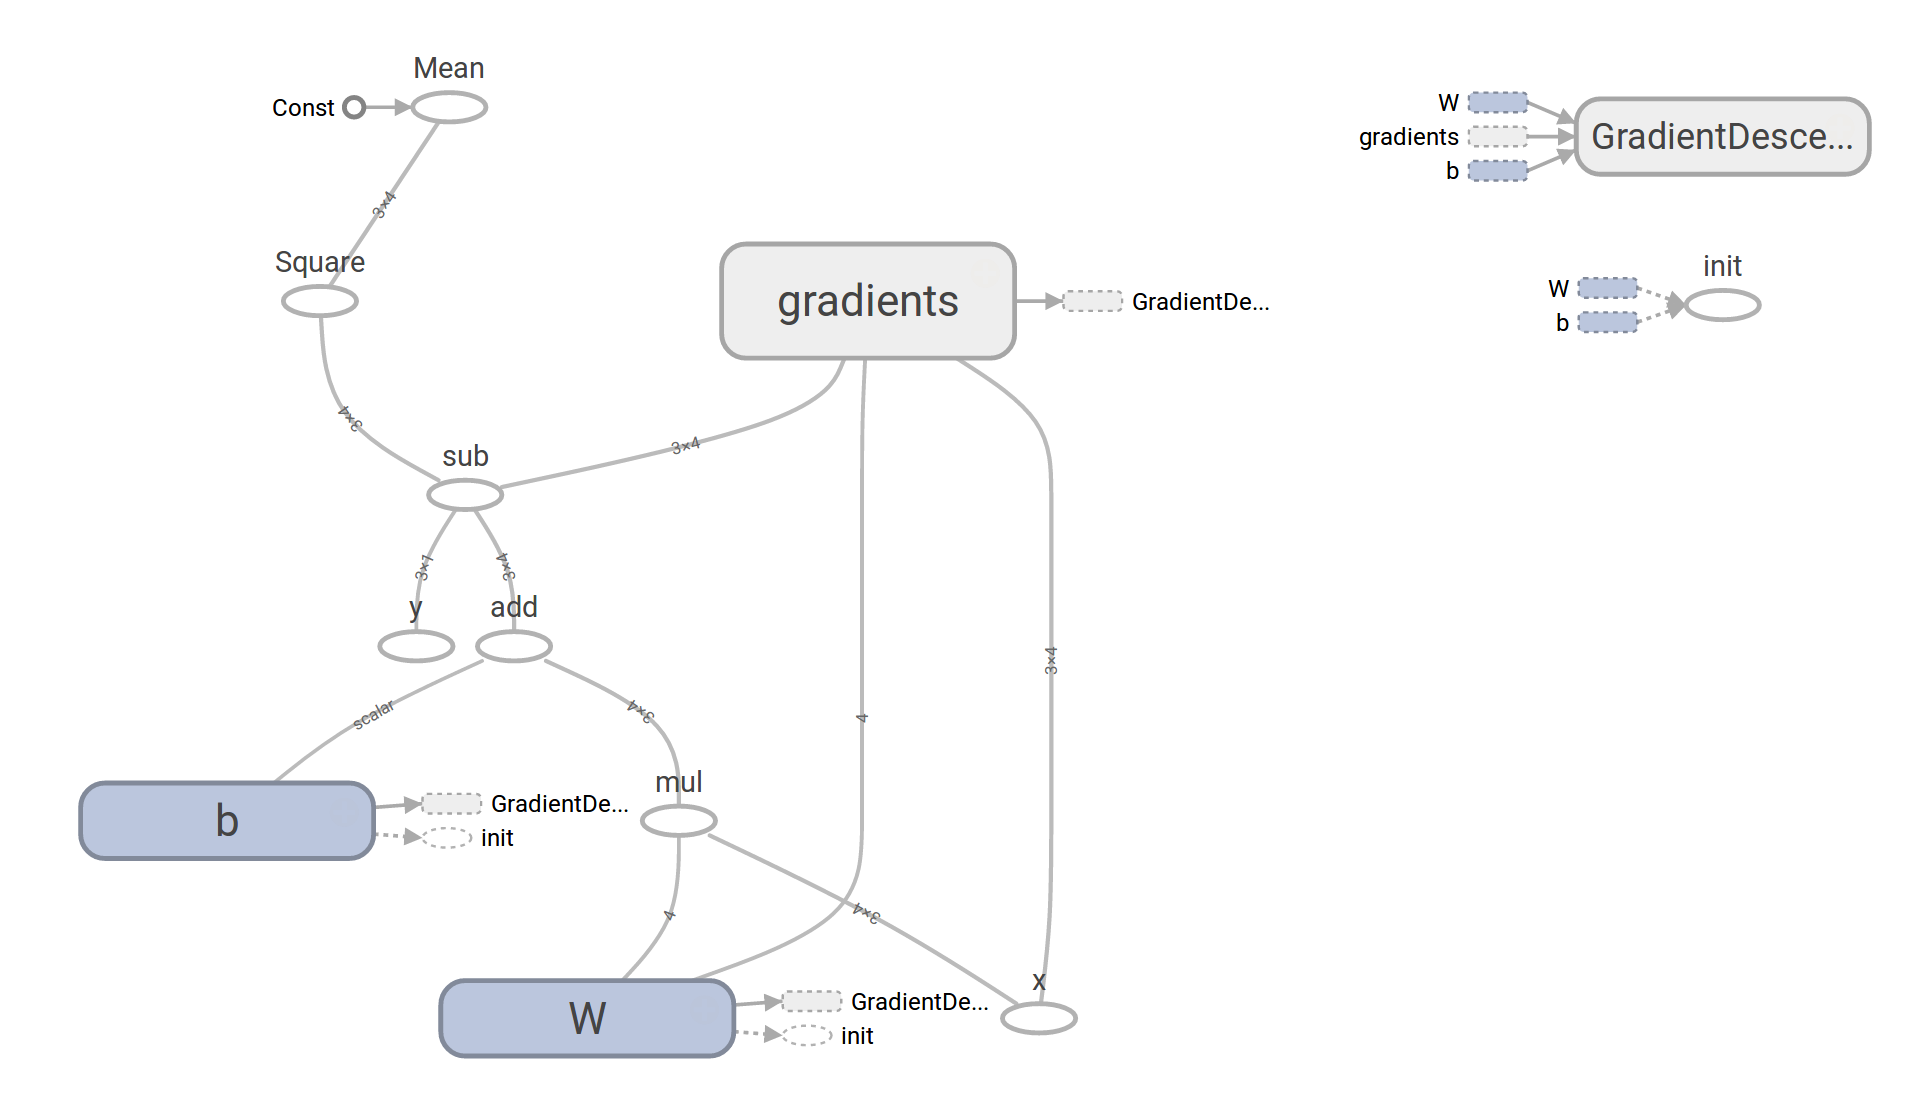

We've successfully trained a simple model in tensorflow. It's time to try something more complex.

In the next section, we're going to make the following modifications to our model:
* We'll let tensorflow initialize the weights and biases for us.
* The x and y placeholders accept a fixed amount of training data. We'd like to feed them with a batch of any size.
* Only a single neuron is being used. We'll implement a complete neural network.

# Part 3: MNIST

This section was inspired by [MNIST For ML Beginners](https://www.tensorflow.org/get_started/mnist/beginners).

MNIST is a simple computer vision classification dataset. The aim is to recognize written digits. All images are of the same size and the digits are centered.

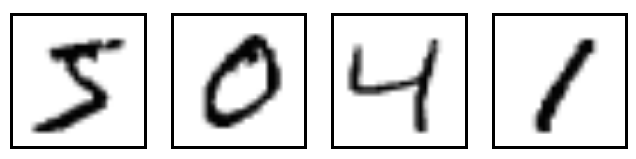

Let's modify our code to fit this task.

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers.python.layers import initializers

# import data
mnist = input_data.read_data_sets("data/mnist", one_hot=True)

# set parameters
learning_rate = 0.5
number_of_iterations = 100

# create the model
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

W = tf.get_variable("W", shape = (784, 10), dtype=tf.float32, initializer=initializers.xavier_initializer())
b = tf.get_variable("b", shape=(10,), dtype=tf.float32, initializer=tf.zeros_initializer())
linear_model = tf.matmul(x, W) + b

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=linear_model))
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(linear_model, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
  
    sess.run(init_op)
    
    # training
    for _ in range(number_of_iterations):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        
        sess.run(train_step, feed_dict = {
            x: batch_xs,
            y: batch_ys
        })
        
    # evaluation
    accuracy = sess.run(accuracy, feed_dict = {
        x: mnist.test.images,
        y: mnist.test.labels
    })
    
print("\nTrained for %d iterations" % number_of_iterations)
print("Accuracy: %.2f%%" % (accuracy * 100))

The above code is an implementation of a logistic regression. What I would like you to do now is to try to extend it to a single-layer perceptron.

#### Task 2:
Implement a **single-layer perceptron** with an arbitrary number of layers and neurons. To achieve a better test accuracy, you might need to alter the number of training steps and the learning rate.

##### Hints:
* **tf.nn.relu** might come handy
* graph of a single-layer perceptron below

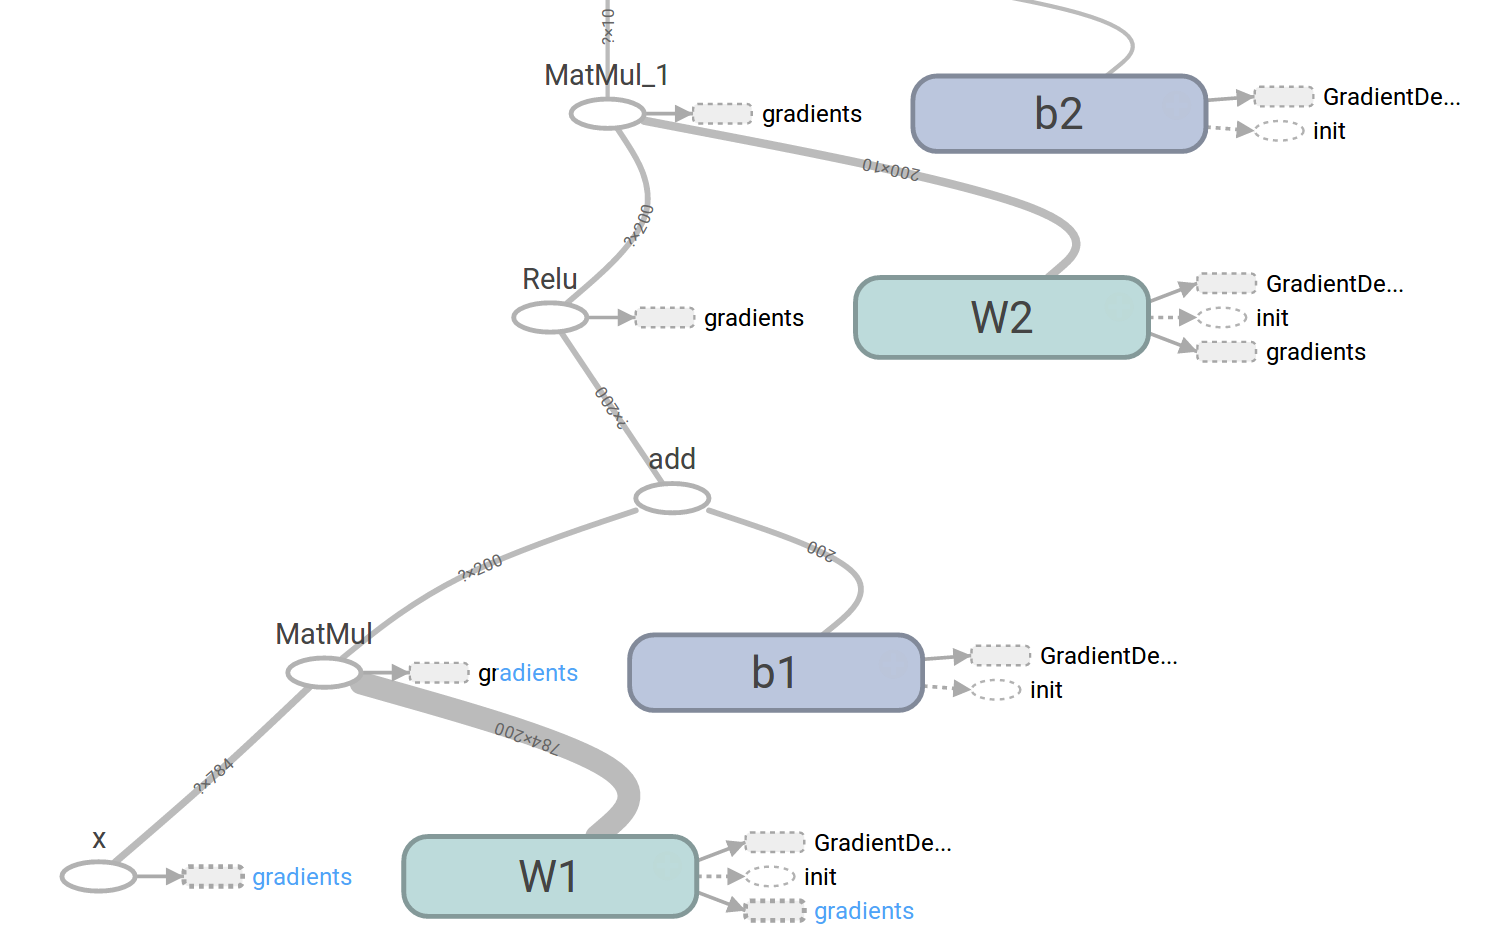

In [ ]:
# TODO